In [49]:
import numpy as np
import MSMRD as mrd
import MSMRD.integrators as integrators
import pickle
from MSMRD.trajectories import allTrajs
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
#define MSMmodel class to read in data
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
# Create a child class from the main class in trajectories_class.py
class asym2Dtraj(allTrajs):
    def __init__(self, centers=None, Trajs=None):
        super(asym2Dtraj, self).__init__(Trajs)
        if centers == None:
            centers = []
        self.centers = centers
        self.innerMSMrad = 2.0
        self.entryRad = 2.6
        self.bathRad = 3.0
        self.bathRadOut = 4.0
        self.angularPartitions = 45
        self.entryRings = 5
        self.exitRings = 5
        self.radialPartitions = self.entryRings + self.exitRings
        self.radialIncrementEntry = (self.entryRad - self.innerMSMrad)/float(self.entryRings)
        self.radialIncrementExit = (self.bathRad - self.entryRad)/float(self.exitRings)
        self.Ncenters = len(self.centers)
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    def getState(self, coord, prevst):
        radius = np.linalg.norm(coord)
        # inner MSM
        if radius < self.innerMSMrad:
            cen2coord = self.centers - coord
            norm = np.linalg.norm(cen2coord, axis = 1)
            index = np.argmin(norm)
            if (norm[index] <= 0.2 ):
                return index
            # if no new state found, return previous state
            return prevst
        elif radius > self.bathRad:
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            assert(angularState < self.angularPartitions)
            return self.Ncenters + self.radialPartitions*self.angularPartitions + angularState
        # Entry states
        elif radius < self.entryRad:
            ringNumber = int((radius - self.innerMSMrad) / self.radialIncrementEntry)
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            return self.Ncenters + ringNumber * self.angularPartitions + angularState
        elif radius < self.bathRad:
            ringNumber = int((radius - self.entryRad) / self.radialIncrementExit)
            theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
            angularState = int(theta/(2*np.pi)*self.angularPartitions)
            return self.Ncenters + (ringNumber + self.entryRings) * self.angularPartitions + angularState
        '''
            for r in range(self.radialPartitions):
                if radius < 
                elif radius < self.entryRad:
                    theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
                    angularState = int(theta/(2*np.pi)*self.angularPartitions)
                    assert(angularState < self.angularPartitions)
                    return self.Ncenters + angularState
                # Exit states 
                elif radius < self.bathRad:
                    theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
                    angularState = int(theta/(2*np.pi)*self.angularPartitions)
                    assert(angularState < self.angularPartitions)
                    return self.Ncenters + self.angularPartitions + angularState
                # Bath state
                elif radius < self.bathRadOut:
                    theta = np.arctan2(coord[0], coord[1]) + np.pi #add pi s.t. angle lies in interval [0, 2pi]
                    angularState = int(theta/(2*np.pi)*self.angularPartitions)
                    assert(angularState < self.angularPartitions)
                    return self.Ncenters + 2*self.angularPartitions + angularState
    '''
        
    # Overwrite getMilestones function
    def getMilestones(self):
        int_th = 2*np.pi/self.angularPartitions
        # inner MSM
        for i in range(self.Ncenters):
            self.milestones[i] = self.centers[i]
        # entry states
        for k in range(self.entryRings):
            for i in range(self.angularPartitions):
                j = i + self.Ncenters + self.angularPartitions * k;
                r = self.innerMSMrad + (k + 0.5)  * self.radialIncrementEntry
                th = i*int_th + 0.5*int_th
                self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # exit states
        for k in range(self.exitRings):
            for i in range(self.angularPartitions):
                j = i + self.Ncenters + self.angularPartitions * (self.entryRings + k) ;
                r = self.entryRad + (k + 0.5)  * self.radialIncrementExit
                th = i*int_th + 0.5*int_th
                self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        # bath states
        for i in range(self.angularPartitions):
            j = i + self.Ncenters + (self.entryRings + self.exitRings)*self.angularPartitions;
            r = 0.5*(self.bathRad + self.bathRadOut)
            th = i*int_th + 0.5*int_th
            self.milestones[j] = [r*np.cos(th), r*np.sin(th)]
        
    
    # Overwrite getRegionMap function
    def getRegionMap(self):
        for i in range(self.Ncenters):
            statename = 'Inner state ' + str(i)
            self.regionMap[i] = statename
        for i in range(self.angularPartitions*self.entryRings):
            statename = 'Entry state ' + str(i)
            j = self.Ncenters + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions*self.exitRings):
            statename = 'Exit state ' + str(i)
            j = self.Ncenters + self.entryRings * self.angularPartitions + i
            self.regionMap[j] = statename
        for i in range(self.angularPartitions):
            statename = 'Bath state ' + str(i)
            j = self.Ncenters + self.radialPartitions * self.angularPartitions + i
            self.regionMap[j] = statename

In [5]:
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
alltrajs = asym2Dtraj(minima, []) # define allTrajs object

In [55]:
model = pickle.load(open('../data/asym2D_longTraj_lag5_Nangular12_50Trajs_10divisions.p'))

In [56]:
T = np.copy(model.tmatrix)
for i in range(model.parameters['NCenters']):
    for j in range(model.parameters['NangularPartitions']):
        T[i,-j-1] = 0
for i in range(len(T)):
    T[i,:] /= np.sum(T[i,:])
#print np.sum(T[:,-15:],axis=1)

In [57]:
MSMlag = 1
msm = mrd.MSM(T, model.centers, lagtime=MSMlag)

In [58]:
p = mrd.particle(np.array([-1.9, -1.9]), 1.)
integrator = integrators.MSMRDexitSampling(msm, 4.0, p, 0.1, model.parameters)

In [10]:
integrator.entryRadius = 0.
print integrator.entryRadius

0.0


In [11]:
sim = mrd.simulation(integrator)
sim.run(1000000, sample=True)

KeyboardInterrupt: 

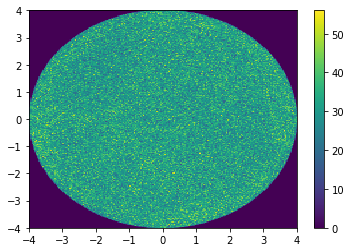

In [13]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=200)
plt.colorbar()

In [16]:
sim.traj[0]

array([ 0.        , -2.76476191, -2.82849443, -1.        ])

In [11]:
hybridStates = []
discStates = []
for angle in range(0, 180):
    for rad in np.arange(2.0,2.6, 0.1):
        p.position = rad*np.array([np.sin(np.pi*angle/90.), np.cos(np.pi*angle/90.)])
        integrator.enterMSM()
        hybridStates.append(integrator.sample(0.1)[3])
        discStates.append(alltrajs.getState(p.position, -1))

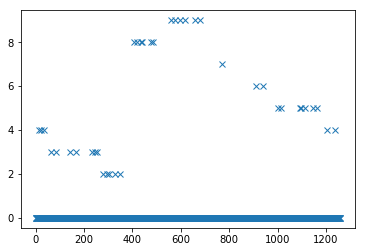

In [12]:
plt.plot(np.array(hybridStates)-np.array(discStates), 'x')

In [11]:
exitPosition = []
for loops in range(300):
    for exitState in range(9, 459):
        integrator.MSM.state = exitState
        integrator.lastState = exitState
        integrator.exitMSM()
        exitPosition.append(integrator.p.position)

In [12]:
exitPositions = np.array(exitPosition)

In [13]:
exitPositions.shape

(135000, 2)

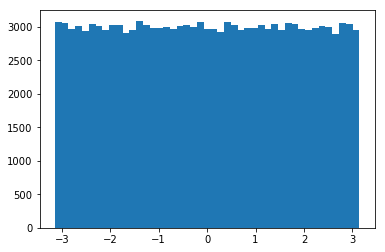

In [15]:
hist = plt.hist(np.arctan2(exitPositions[:,0], exitPositions[:,1]), bins = 45)

((array([ 14.,  32.,  19.,  31.,  17.,  21.,  21.,  25.]),
  array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
  <a list of 8 Patch objects>),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]))

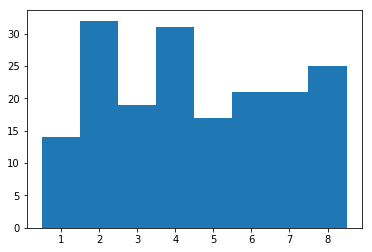

In [36]:
discreteHistogram(np.array(entryStates))

In [33]:
integrator.p.position
integrator.enterMSM()
integrator.sample(0.1)

[0.010000000000000002, 0.0, 0.0, 934.0]

In [64]:
state = 2
times = []
for run in range(10000):
    state = 2
    timer = 0
    while state < msm.T.shape[0] - 12:
        timer += 1
        state = np.random.choice(T.shape[0], p = msm.T[state,:])
    times.append(timer)

In [65]:
FPTs = np.array(times)

In [66]:
np.mean(FPTs*0.1)

2.4369100000000001

In [67]:
BDtransitionTimesMSM = pickle.load(open('MTTs_convergence.p'))

In [68]:
BDtransitionTimesMSM[48][2,9]

2.0997769072900434

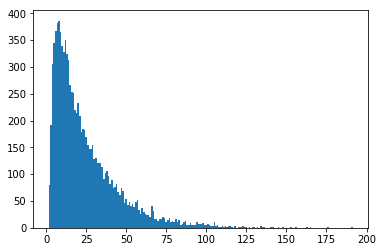

In [37]:
FPThist = discreteHistogram(FPTs)

In [44]:
import pickle

In [46]:
MFPTs = pickle.load(open('2Dasym_lag10_reference.p'))

In [48]:
MFPTs[2,9]

2.0992378968111955